# Livrable 3

## 1. Introduction

Dans le cadre du projet **Leyenda**, l'objectif de ce livrable est de développer un système automatique capable de générer des légendes descriptives pour des photographies, en utilisant des techniques avancées d'apprentissage profond. Ce livrable s'appuie sur l'un des datasets de référence dans le domaine, **MS COCO**, qui contient des images annotées manuellement avec des descriptions textuelles détaillées.

Pour accomplir cette tâche, nous avons conçu un modèle de **réseau de neurones convolutionnel (CNN)** couplé à un **réseau de neurones récurrent (RNN)**. Le CNN est utilisé pour extraire les caractéristiques visuelles des images, tandis que le RNN, notamment un **modèle de type LSTM (Long Short-Term Memory)**, traite ces caractéristiques pour générer des séquences de mots, formant ainsi des légendes.

Le modèle suit un pipeline en plusieurs étapes, commençant par le prétraitement des images et des légendes textuelles, suivi de l'entraînement du modèle à partir des données étiquetées. Ce document détaille les différentes phases de développement, l'architecture du modèle, ainsi que les résultats obtenus lors des phases de test. 

L'objectif final de ce livrable est de présenter une solution automatisée, capable d'être déployée pour une utilisation dans des environnements réels, où elle pourrait analyser de nouvelles images et générer des légendes précises, en s'appuyant sur l'expérience acquise lors de l'entraînement sur MS COCO.

## 2. Importation et exploration des données

### 2.1. Code d'importation

Pour la réalisation de ce projet de captioning d'images, plusieurs librairies sont nécessaires afin de gérer les différentes étapes du traitement des données, de l'entraînement du modèle et de la visualisation des résultats.

In [25]:
import os, zipfile, random, json, collections, urllib, time

import numpy as np
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt

### 2.2. Configuration et initialisation des répertoires et paramètres

#### 1. Chemin du projet

In [26]:
project_path = os.getcwd()

#### 2. Définition des chemins pour les données

In [27]:
paths = {
    "data_dir": os.path.join(project_path, "data"),
    "train_images_dir": os.path.join(project_path, "data", "train2014"),
    "annotations_dir": os.path.join(project_path, "data", "annotations"),
    "train_images_zip": os.path.join(project_path, "data", "train2014.zip"),
    "annotations_zip": os.path.join(project_path, "data", "annotations_trainval2014.zip"),
    "annotation_file": os.path.join(project_path, "data", "annotations", "captions_train2014.json"),
    "tokenizer_file": os.path.join(project_path, "data", "tokenizer.json"),
    "checkpoint_path": os.path.join(project_path, "data", "checkpoints"),
}

#### 3. Création du répertoire de données

In [28]:
if not os.path.exists(paths["data_dir"]):
    os.makedirs(paths["data_dir"])

#### 4. URL des fichiers du dataset COCO

In [29]:
COCO_URLs = {
    "images": "http://images.cocodataset.org/zips/train2014.zip",
    "annotations": "http://images.cocodataset.org/annotations/annotations_trainval2014.zip"
}

#### 5. Paramètres du modèle

In [56]:
epochs = 10

batch_size = 32
buffer_size = 1000

embedding_dim = 256

units = 512

top_k = 10000
vocab_size = top_k + 1

### 2.3. Téléchargement et extraction des données COCO

L’un des prérequis essentiels pour entraîner un modèle de captioning est de disposer d'un dataset riche en images et légendes correspondantes. Dans ce projet, nous utilisons le dataset COCO 2014 qui contient un grand nombre d’images d’entraînement et des annotations sous forme de légendes textuelles. Ce bloc de code permet de gérer automatiquement le téléchargement et l'extraction de ces données dans l'environnement de travail.

In [31]:
def download_and_extract(zip_path, extract_dir, url, description):
    # Téléchargement du fichier zip si non présent
    if not os.path.exists(zip_path):
        print(f"Téléchargement du dataset COCO {description} en cours...")
        urllib.request.urlretrieve(url, zip_path)
        print(f"Téléchargement des {description} terminé.")
    else:
        print(f"Le fichier zip des {description} existe déjà.")

    # Vérification et extraction si nécessaire
    if not os.path.exists(extract_dir):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            print(f"Extraction des fichiers {description} en cours...")
            zip_ref.extractall(os.path.dirname(extract_dir))
            print(f"Extraction des {description} terminée.")
    else:
        print(f"Les fichiers {description} ont déjà été extraits.")

    # Affichage du nombre de fichiers extraits
    if os.path.exists(extract_dir):
        extracted_files = os.listdir(extract_dir)
        print(f"{len(extracted_files)} fichiers extraits dans {extract_dir}")
    else:
        print(f"Erreur : le dossier d'extraction des {description} n'existe pas.")

# Téléchargement et extraction des images et annotations en générant les chemins à la volée
download_and_extract(
    paths["train_images_zip"],
    paths["train_images_dir"],
    COCO_URLs["images"],
    "images"
)

download_and_extract(
    paths["annotations_zip"],
    paths["annotations_dir"],
    COCO_URLs["annotations"],
    "annotations"
)

Le fichier zip des images existe déjà.
Extraction des fichiers images en cours...
Extraction des images terminée.
82783 fichiers extraits dans /Users/mohamed/Documents/FISE A5/z/livrable_3/data/train2014
Le fichier zip des annotations existe déjà.
Extraction des fichiers annotations en cours...
Extraction des annotations terminée.
6 fichiers extraits dans /Users/mohamed/Documents/FISE A5/z/livrable_3/data/annotations


### 2.5. Création de la correspondance image-légende

Ce bloc de code a pour objectif de créer une structure de données associant chaque image à ses légendes correspondantes à partir des annotations fournies dans le fichier JSON du dataset COCO. Cela permettra ensuite d’entraîner un modèle de captioning, où chaque image sera liée à une ou plusieurs légendes descriptives.

In [32]:
def create_image_caption_mapping(annotation_file, image_dir):
    # Lire le fichier d'annotation JSON
    with open(annotation_file, 'r') as f:
        annotations = json.load(f)
    
    # Dictionnaire pour associer chaque image à ses légendes
    image_path_to_caption = collections.defaultdict(list)

    # Parcourir chaque annotation
    for annotation in annotations['annotations']:
        # Ajouter les balises de début et de fin à chaque légende
        caption = f"<start> {annotation['caption']} <end>"
        
        # Construire le chemin de l'image correspondant
        image_id = annotation['image_id']
        image_filename = f'COCO_train2014_{image_id:012d}.jpg'
        image_path = os.path.join(image_dir, image_filename)
        
        # Associer la légende à l'image
        image_path_to_caption[image_path].append(caption)

    return image_path_to_caption

image_path_to_caption = create_image_caption_mapping(
    paths["annotation_file"], 
    paths["train_images_dir"]
)

### 2.6. Sélection d'images et de légendes aléatoires

Ce bloc de code permet de sélectionner un échantillon aléatoire d'images et leurs légendes associées à partir du dictionnaire d'annotations précédemment généré. Cette étape est utile pour créer un sous-ensemble du dataset complet, souvent nécessaire lorsque l’entraînement est long ou que les ressources sont limitées.

In [33]:
def get_random_image_paths_and_captions(image_path_to_caption, num_samples=2000):
    # Prendre tous les chemins d'images
    image_paths = list(image_path_to_caption.keys())
    
    # Sélectionner un échantillon aléatoire d'images
    train_image_paths = random.sample(image_paths, num_samples)

    # Initialiser les listes pour les légendes et les chemins d'images dupliqués
    train_captions = []
    img_name_vector = []

    # Remplir les listes en fonction des annotations
    for image_path in train_image_paths:
        caption_list = image_path_to_caption[image_path]
        # Ajouter chaque légende dans train_captions
        train_captions.extend(caption_list)
        # Ajouter le chemin de l'image dupliqué selon le nombre d'annotations
        img_name_vector.extend([image_path] * len(caption_list))

    return img_name_vector, train_captions

img_name_vector, train_captions = get_random_image_paths_and_captions(image_path_to_caption, 5000)


25017 25017
<start> a sign written in yellow that says righteous public republican glory hole  <end>


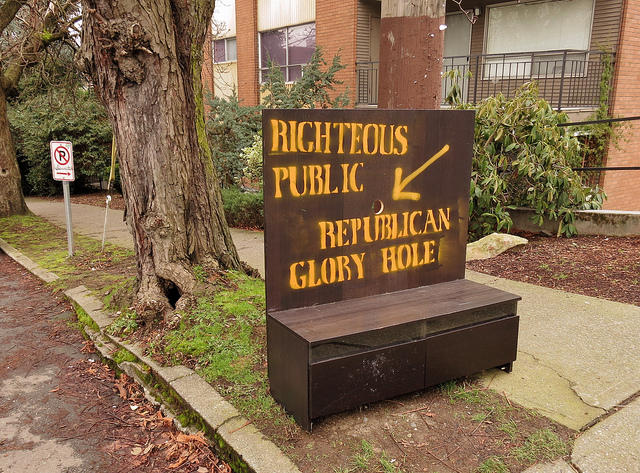

In [34]:
print(len(train_captions), len(img_name_vector))
print(train_captions[0])
Image.open(img_name_vector[0])

### 2.7. Création d’un extracteur de caractéristiques d’images

L'extraction des caractéristiques d'une image est une étape cruciale dans un pipeline de captioning d'images. Le modèle InceptionV3, pré-entraîné sur le dataset ImageNet, est couramment utilisé pour cette tâche car il est capable d'extraire des représentations denses et informatives d'images.

In [35]:
def create_image_feature_extractor():
    # Téléchargement du modèle InceptionV3 pré-entraîné sur ImageNet sans la couche supérieure
    image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

    # Récupérer l'entrée du modèle InceptionV3
    new_input = image_model.input

    # Récupérer la sortie de la dernière couche cachée (dense)
    hidden_layer = image_model.layers[-1].output

    # Créer un nouveau modèle qui extrait les caractéristiques denses des images
    image_features_extract_model = tf.keras.Model(inputs=new_input, outputs=hidden_layer)

    return image_features_extract_model

image_features_extract_model = create_image_feature_extractor()

### 2.8. Prétraitement et extraction des caractéristiques des image

L'objectif de ce bloc de code est de prétraiter les images, d’extraire leurs caractéristiques à l'aide du modèle InceptionV3, et de sauvegarder ces caractéristiques sous forme de fichiers .npy pour une utilisation ultérieure dans le modèle de captioning.

In [36]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    return img, image_path

def save_image_features(batch_features, paths):
    for bf, p in zip(batch_features, paths):
        path_of_feature = p.numpy().decode("utf-8") 

        np.save(path_of_feature, bf.numpy())

# Pré-traitement des images
encode_train = sorted(set(img_name_vector))

# Créer un Dataset TensorFlow pour traiter les images par lots
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# Parcourir le dataset batch par batch pour extraire les caractéristiques des images
for img, path in tqdm(image_dataset):
    # Extraire les caractéristiques du batch actuel avec InceptionV3
    batch_features = image_features_extract_model(img)
    # Redimensionner les caractéristiques (16, 8, 8, 2048) en (16, 64, 2048)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
    # Sauvegarder les caractéristiques extraites pour chaque image dans le batch
    save_image_features(batch_features, path)

100%|██████████| 313/313 [03:10<00:00,  1.65it/s]


### 2.9. Prétraitement des légendes et sauvegarde du tokenizer

Ce bloc de code s’occupe de convertir les légendes d’entraînement en séquences de tokens, de les normaliser à une longueur commune, et de sauvegarder le tokenizer pour une utilisation ultérieure. Ce processus est essentiel pour préparer les légendes dans un format compréhensible par un modèle de machine learning.

In [37]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

def preprocess_captions(train_captions, top_k=5000):
    # Initialiser le tokenizer avec les paramètres spécifiques
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=top_k, 
        oov_token="<unk>", 
        filters=r'!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '
        )
    
    # Construire le vocabulaire basé sur les légendes
    tokenizer.fit_on_texts(train_captions)

    # Ajouter un token spécial pour remplir les légendes courtes
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'

    # Convertir les légendes en séquences de tokens
    train_seqs = tokenizer.texts_to_sequences(train_captions)

    # Remplir les séquences à la longueur maximale
    cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

    # Calculer la longueur maximale des séquences
    max_length = calc_max_length(train_seqs)

    return cap_vector, tokenizer, max_length

def save_tokenizer(tokenizer, save_path):
    tokenizer_json = tokenizer.to_json()
    with open(save_path, 'w', encoding='utf-8') as f:
        f.write(json.dumps(tokenizer_json, ensure_ascii=False))
    print(f'Tokenizer sauvegardé dans {save_path}.')

# Prétraitement des légendes d'entraînement
cap_vector, tokenizer, max_length = preprocess_captions(train_captions, top_k)

# Sauvegarder le tokenizer pour un usage ultérieur
tokenizer_save_path = paths["tokenizer_file"]
save_tokenizer(tokenizer, tokenizer_save_path)

Tokenizer sauvegardé dans /Users/mohamed/Documents/FISE A5/z/livrable_3/data/tokenizer.json.


### 2.10. Création de la correspondance image-légende et division du dataset

L’objectif de ce segment de code est de créer une structure de données qui associe chaque image à ses légendes correspondantes, puis de diviser le dataset en ensembles d’entraînement et de validation. Cette étape est essentielle pour évaluer les performances du modèle tout en évitant le surapprentissage.

In [38]:
def create_image_caption_mapping(img_name_vector, cap_vector):
    img_to_cap_vector = collections.defaultdict(list)
    for img, cap in zip(img_name_vector, cap_vector):
        img_to_cap_vector[img].append(cap)
    
    return img_to_cap_vector

def split_dataset(img_to_cap_vector, split_ratio=0.8):
    # Récupérer les clés (chemins des images, sans doublons)
    img_keys = list(img_to_cap_vector.keys())
    random.shuffle(img_keys)  # Mélanger les clés

    # Diviser les indices selon le ratio défini
    slice_index = int(len(img_keys) * split_ratio)
    img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

    # Construire les listes d'entrainement et de validation
    img_name_train, cap_train = [], []
    img_name_val, cap_val = [], []

    # Boucle pour l'ensemble d'entraînement
    for imgt in img_name_train_keys:
        capt_len = len(img_to_cap_vector[imgt])
        img_name_train.extend([imgt] * capt_len)
        cap_train.extend(img_to_cap_vector[imgt])

    # Boucle pour l'ensemble de validation
    for imgv in img_name_val_keys:
        capv_len = len(img_to_cap_vector[imgv])
        img_name_val.extend([imgv] * capv_len)
        cap_val.extend(img_to_cap_vector[imgv])

    return img_name_train, cap_train, img_name_val, cap_val

# Association des images avec leurs légendes
img_to_cap_vector = create_image_caption_mapping(img_name_vector, cap_vector)

# Division du dataset en ensembles d'entraînement et de validation
img_name_train, cap_train, img_name_val, cap_val = split_dataset(img_to_cap_vector, split_ratio=0.8)

# Affichage des tailles des jeux d'entraînement et de validation
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

num_steps = len(img_name_train) // batch_size

### 2.11. Création du dataset d'entraînement avec préchargement des caractéristiques

Ce code gère la création d’un dataset TensorFlow à partir des chemins d’images et de leurs légendes. Les images ne sont pas directement chargées mais plutôt leurs caractéristiques extraites (sous forme de fichiers .npy), préalablement générées à l’aide du modèle InceptionV3.

In [39]:
# Les formes des vecteurs extraits de InceptionV3
features_shape = 2048
attention_features_shape = 64

def map_func(img_name, cap):
    img_path = img_name.decode('utf-8') + '.npy'
    if os.path.exists(img_path):
        img_tensor = np.load(img_path)
    else:
        raise FileNotFoundError(f"Le fichier {img_path} n'existe pas.")
    
    return img_tensor, cap

def create_dataset(img_names, captions, batch_size=batch_size, buffer_size=buffer_size):
    # Création du dataset à partir des images et des légendes
    dataset = tf.data.Dataset.from_tensor_slices((img_names, captions))

    # Utiliser map pour charger les fichiers numpy
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Mélanger les données et les diviser en batchs
    dataset = dataset.shuffle(buffer_size).batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

# Création du dataset d'entraînement
dataset = create_dataset(img_name_train, cap_train)

## 3. Le modèle

### 3.1. Classe : CNN_Encoder

La classe CNN_Encoder est un encodeur d'images conçu pour transformer les caractéristiques extraites des images en une représentation adaptée à l'entrée dans un modèle séquentiel, tel qu'un réseau de neurones récurrent (RNN). Dans ce cas, les caractéristiques des images sont déjà extraites par InceptionV3 et ne nécessitent pas un traitement supplémentaire complexe. L'encodeur agit simplement comme un intermédiaire en réduisant la dimensionnalité et en appliquant une couche dense avec activation ReLU et un Dropout pour régulariser l'apprentissage.

In [40]:
class CNN_Encoder(tf.keras.Model):
    # Comme les images sont déjà prétraités par InceptionV3 est représenté sous forme compacte
    # L'encodeur CNN ne fera que transmettre ces caractéristiques à une couche dense
    def __init__(self, embedding_dim, dropout_rate=0.5):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        x = self.dropout(x)
        return x

### 3.2. Classe : BahdanauAttention

La classe BahdanauAttention implémente le mécanisme d'attention proposé par Bahdanau et al. en 2015. L'attention permet au modèle de se concentrer sur certaines parties des données d'entrée (dans ce cas, les caractéristiques des images) en fonction de l'état caché courant du décodeur (par exemple, un RNN ou un LSTM). Cela améliore l'apprentissage en pondérant différemment les caractéristiques en fonction de leur pertinence pour générer la légende à chaque étape.

In [41]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units, dropout_rate=0.5):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, features, hidden, training=False):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        attention_hidden_layer = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        score = self.V(attention_hidden_layer)

        attention_weights = tf.nn.softmax(score, axis=1)
        attention_weights = self.dropout(attention_weights, training=training)

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

### 3.3 Classe : RNN_Decoder

La classe RNN_Decoder implémente un décodeur basé sur un réseau de neurones récurrents (RNN), plus précisément un LSTM (Long Short-Term Memory), utilisé pour générer des séquences de texte à partir de caractéristiques d'images extraites et du vecteur de contexte fourni par un mécanisme d'attention. Cette classe fait partie d'un modèle de captioning d'images.

In [42]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        
        # Remplacement de la couche GRU par LSTM
        self.lstm = tf.keras.layers.LSTM(self.units,
                                         return_sequences=True,
                                         return_state=True,
                                         recurrent_initializer='glorot_uniform')

        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden[0])

        # Passage du mot courant à la couche embedding
        x = self.embedding(x)
        
        # Concaténation du vecteur de contexte et de l'embedding
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # Passage du vecteur concaténé à la LSTM
        output, hidden_state, cell_state = self.lstm(x, initial_state=hidden)

        # Couche dense après LSTM
        y = self.fc1(output)

        # Reshape du résultat
        y = tf.reshape(y, (-1, y.shape[2]))

        # Dernière couche dense pour obtenir la prédiction du vocabulaire
        y = self.fc2(y)

        return y, [hidden_state, cell_state], attention_weights

    def reset_state(self, batch_size):
        # Pour LSTM, initialiser deux états : hidden state et cell state
        return [tf.zeros((batch_size, self.units)), tf.zeros((batch_size, self.units))]

### 3.4. Création de l'encodeur

In [43]:
# Création de l'encodeur
encoder = CNN_Encoder(embedding_dim)

### 3.5. Création du décodeur

In [44]:
# Création du décodeur
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

### 3.6. Optimiseur et fonction de perte

Ces éléments jouent un rôle clé dans la phase d'entraînement du modèle de captioning. L'optimiseur ajuste les poids du modèle pour minimiser la perte, et la fonction de perte mesure la différence entre les prédictions du modèle et les légendes réelles.

In [45]:
# Optimiseur ADAM
optimizer = tf.keras.optimizers.Adam()

# La fonction de perte
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### 3.7. Gestion des checkpoints

Ce code permet de sauvegarder et de restaurer l'état du modèle à différents points pendant l'entraînement. Les checkpoints contiennent les poids du modèle (pour l'encodeur et le décodeur), ainsi que l'état de l'optimiseur, ce qui permet de reprendre l'entraînement à partir du dernier point de sauvegarde en cas d'interruption.

In [46]:
def setup_checkpoint(encoder, decoder, optimizer, max_to_keep=5):
    # Créer le checkpoint
    ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
    ckpt_manager = tf.train.CheckpointManager(ckpt, paths["checkpoint_path"], max_to_keep=max_to_keep)
    
    start_epoch = 0
    
    # Restaurer le dernier checkpoint s'il existe
    if ckpt_manager.latest_checkpoint:
        start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
        print(f"Restoration du dernier checkpoint à l'époque {start_epoch}.")
        ckpt.restore(ckpt_manager.latest_checkpoint)
    else:
        print("Aucun checkpoint trouvé, entraînement à partir de zéro.")
    
    return ckpt_manager, start_epoch

ckpt_manager, start_epoch = setup_checkpoint(encoder, decoder, optimizer)


Aucun checkpoint trouvé, entraînement à partir de zéro.


### 3.8. Fonction : train_step

La fonction train_step représente une étape unique d'entraînement du modèle, où une image et sa légende cible sont traitées pour mettre à jour les poids du modèle. Cette étape comprend la propagation avant (encodage des images, génération des légendes), le calcul de la perte, et la rétropropagation pour ajuster les poids à l'aide des gradients.

In [47]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # Initialisation de l'état caché pour chaque batch
    hidden = decoder.reset_state(batch_size=target.shape[0])

    # Initialiser l'entrée du décodeur avec le token <start> pour chaque séquence
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:  # Calcul des gradients pour optimiser les poids du modèle
        # Encoder l'image (extraction des features avec l'encodeur)
        features = encoder(img_tensor)

        # Boucle sur chaque étape de la séquence (chaque mot)
        for i in range(1, target.shape[1]):
            # Prédiction du i-ème mot avec le décodeur
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            # Calcul de la perte pour cette étape (comparaison entre la vérité et la prédiction)
            loss += loss_function(target[:, i], predictions)

            # Le mot correct est utilisé comme entrée pour la prochaine prédiction
            dec_input = tf.expand_dims(target[:, i], 1)

    # Calcul de la perte moyenne par séquence
    total_loss = loss / int(target.shape[1])

    # Liste des variables entraînables (encodeur et décodeur)
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    # Calcul des gradients en fonction de la perte
    gradients = tape.gradient(loss, trainable_variables)
    
    # Application des gradients pour mettre à jour les poids du modèle
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

### 3.9. Fonction : train_model()

La fonction train_model() exécute l'entraînement du modèle de captioning d'images sur un nombre spécifié d'époques. À chaque époque, elle parcourt le dataset d'entraînement, met à jour les poids du modèle à l'aide des gradients, et sauvegarde les checkpoints périodiquement. Cette fonction affiche également la progression et le temps d'exécution pour chaque époque.

In [57]:
def train_model(epochs, start_epoch, dataset, num_steps, ckpt_manager):
    loss_plot = []

    for epoch in range(start_epoch, epochs):
        start = time.time()
        total_loss = 0

        # Barre de progression pour l'epoch en cours
        with tqdm(total=num_steps, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:

            # Parcourir les batches d'entraînement
            for batch, (img_tensor, target) in enumerate(dataset):
                # Effectuer une étape d'entraînement
                batch_loss, t_loss = train_step(img_tensor, target)
                total_loss += t_loss

                # Mise à jour de la barre de progression
                pbar.set_postfix({"Batch Loss": f"{batch_loss.numpy() / int(target.shape[1]):.4f}"})
                pbar.update(1)

            # Sauvegarder la perte moyenne pour l'epoch
            loss_plot.append(total_loss / num_steps)

            # Sauvegarder les checkpoints tous les 5 epochs
            if epoch % 5 == 0:
                ckpt_manager.save()
                print(f'Checkpoint sauvegardé à l\'epoch {epoch + 1}')

        # Afficher la perte moyenne et le temps pris pour l'epoch
        print(f'\nEpoch {epoch + 1} Loss {total_loss / num_steps:.6f}')
        print(f'Temps pris pour l\'epoch {epoch + 1}: {time.time() - start:.2f} secondes\n')

    return loss_plot

# Lancer l'entraînement
loss_plot = train_model(epochs, start_epoch, dataset, num_steps, ckpt_manager)

Epoch 1/10: 626batch [06:55,  1.73batch/s, Batch Loss=0.5214]                      2024-10-22 19:57:46.213780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 1/10: 626batch [06:55,  1.51batch/s, Batch Loss=0.5214]


Checkpoint sauvegardé à l'epoch 1

Epoch 1 Loss 0.508359
Temps pris pour l'epoch 1: 415.76 secondes



Epoch 2/10: 626batch [08:09,  1.72batch/s, Batch Loss=0.4783]                      2024-10-22 20:05:55.471869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 2/10: 626batch [08:09,  1.28batch/s, Batch Loss=0.4783]



Epoch 2 Loss 0.454907
Temps pris pour l'epoch 2: 489.20 secondes



Epoch 3/10: 626batch [06:50,  1.72batch/s, Batch Loss=0.3735]                      2024-10-22 20:12:45.562687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 3/10: 626batch [06:50,  1.53batch/s, Batch Loss=0.3735]



Epoch 3 Loss 0.403648
Temps pris pour l'epoch 3: 410.09 secondes



Epoch 4/10: 626batch [06:43,  1.76batch/s, Batch Loss=0.3599]                      2024-10-22 20:19:29.098840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 4/10: 626batch [06:43,  1.55batch/s, Batch Loss=0.3599]



Epoch 4 Loss 0.355595
Temps pris pour l'epoch 4: 403.54 secondes



Epoch 5/10: 626batch [06:54,  1.54batch/s, Batch Loss=0.2306]                      2024-10-22 20:26:23.181125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 5/10: 626batch [06:54,  1.51batch/s, Batch Loss=0.2306]



Epoch 5 Loss 0.310799
Temps pris pour l'epoch 5: 414.08 secondes



Epoch 6/10: 626batch [07:00,  1.58batch/s, Batch Loss=0.2816]                      2024-10-22 20:33:23.946974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 6/10: 626batch [07:00,  1.49batch/s, Batch Loss=0.2816]


Checkpoint sauvegardé à l'epoch 6

Epoch 6 Loss 0.270975
Temps pris pour l'epoch 6: 420.82 secondes



Epoch 7/10: 626batch [06:46,  1.83batch/s, Batch Loss=0.2292]                      2024-10-22 20:40:10.108034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 7/10: 626batch [06:46,  1.54batch/s, Batch Loss=0.2292]



Epoch 7 Loss 0.235723
Temps pris pour l'epoch 7: 406.11 secondes



Epoch 8/10: 626batch [06:39,  1.80batch/s, Batch Loss=0.1872]                      2024-10-22 20:46:49.309301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 8/10: 626batch [06:39,  1.57batch/s, Batch Loss=0.1872]



Epoch 8 Loss 0.206655
Temps pris pour l'epoch 8: 399.20 secondes



Epoch 9/10: 626batch [06:49,  1.78batch/s, Batch Loss=0.1832]                      2024-10-22 20:53:39.124163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 9/10: 626batch [06:49,  1.53batch/s, Batch Loss=0.1832]



Epoch 9 Loss 0.183226
Temps pris pour l'epoch 9: 409.81 secondes



Epoch 10/10: 626batch [07:06,  1.63batch/s, Batch Loss=0.2226]                      2024-10-22 21:00:45.462667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 10/10: 626batch [07:06,  1.47batch/s, Batch Loss=0.2226]


Epoch 10 Loss 0.163912
Temps pris pour l'epoch 10: 426.34 secondes



### 3.10. Fonction : plot_metrics()

La fonction plot_metrics() est utilisée pour tracer la courbe de la perte d'entraînement au fil des époques. Bien que dans cet exemple seule la perte soit tracée, la fonction est conçue pour permettre l'ajout d'autres courbes, comme la précision ou le score BLEU, si nécessaire.

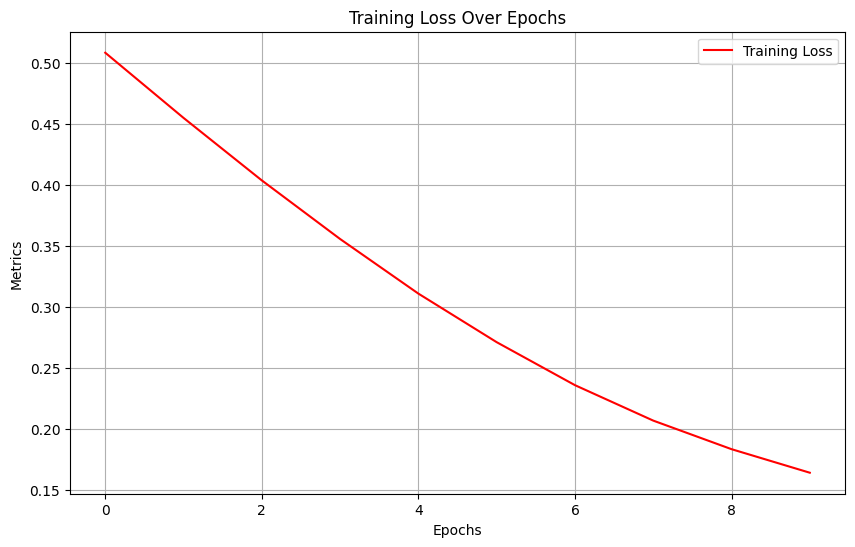

In [58]:
def plot_metrics(loss_plot):
    plt.figure(figsize=(10, 6))
    
    # Tracer la courbe de la perte
    plt.plot(loss_plot, label='Training Loss', color='r')
    
    # Tracer la courbe de la précision
    # plt.plot(accuracy_plot, label='Training Accuracy', color='g')
    
    # Tracer la courbe du score BLEU
    # plt.plot(bleu_plot, label='Training BLEU', color='b')

    # Ajouter des titres et labels
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.title('Training Loss Over Epochs')

    # Ajouter la grille pour faciliter la lecture
    plt.grid(True)

    # Ajouter la légende
    plt.legend()

    # Afficher le plot
    plt.show()

# Appeler la fonction pour afficher les courbes
plot_metrics(loss_plot)

## 4. Test

In [59]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    # Charger et pré-traiter l'image
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    # Passer l'image à l'encodeur
    features = encoder(img_tensor_val)

    # Initialiser l'entrée du décodeur avec le token <start>
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        # Prédire le mot suivant
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        # Sauvegarder les poids d'attention
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        # Sélectionner l'ID du mot prédit avec argmax pour des prédictions plus déterministes
        predicted_id = tf.argmax(predictions, axis=-1).numpy()[0]
        result.append(tokenizer.index_word.get(predicted_id, '<unk>'))

        if tokenizer.index_word.get(predicted_id) == '<end>':
            attention_plot = attention_plot[:len(result), :]
            return result, attention_plot

        # Mettre à jour l'entrée pour le prochain mot
        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot


def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    grid_size = int(np.ceil(np.sqrt(len_result)))

    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(grid_size, grid_size, l+1) 
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()


Image ID: 2667
Real Caption: <start> a black and white photo of a person on the street <end>
Prediction Caption: two men are seen walking across the street <end>


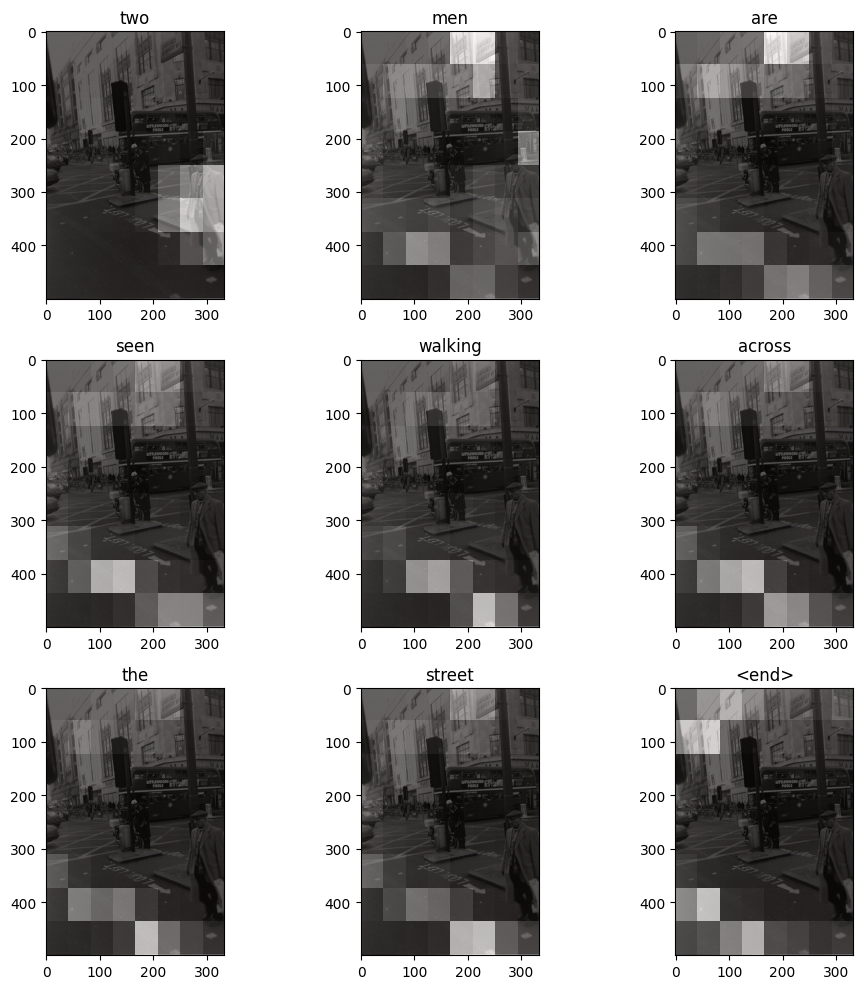

In [63]:
def display_random_annotation(img_name_val, cap_val, tokenizer, num_samples=1):
    for _ in range(num_samples):
        rid = np.random.randint(0, len(img_name_val))
        image = img_name_val[rid]

        # Générer la légende réelle
        real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])

        # Prédire la légende avec le modèle
        result, attention_plot = evaluate(image)

        # Afficher la légende réelle et la légende prédite
        print(f"\nImage ID: {rid}")
        print(f"Real Caption: {real_caption}")
        print(f"Prediction Caption: {' '.join(result)}")

        # Visualiser l'attention
        plot_attention(image, result, attention_plot)

display_random_annotation(img_name_val, cap_val, tokenizer, num_samples=1)